In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [12]:
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("employee_data", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()
df

Found the config file in: /config.json
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,Name,Age,Department,Salary
0,Quincy,58,Legal,64769
1,Xander,46,Operations,79604
2,Frank,44,R&D,88645
3,Hannah,25,HR,61634
4,Leo,42,IT,69256
...,...,...,...,...
49995,Yara,31,Legal,114507
49996,Grace,61,Sales,71374
49997,Xander,36,Sales,73774
49998,Rita,50,IT,74944


In [13]:
# Step 1: Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical columns
label_encoder = LabelEncoder()
df['Department'] = label_encoder.fit_transform(df['Department'])

# Drop non-informative or high-cardinality columns
if 'Name' in df.columns:
    df = df.drop(columns=['Name'])  # 'Name' is likely not predictive

# Optional: Check for missing values
if df.isnull().sum().any():
    df = df.dropna()  # or use df.fillna(method='ffill') for imputation

# Step 2: Define Features and Target
X = df.drop('Salary', axis=1)  # Features: Age and Department
y = df['Salary']               # Target: Salary

# Optional: Feature Scaling (especially useful for models sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split the Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 4: Train a Regression Model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [17]:
# Step 5: Make Predictions
predictions = model.predict(X_test)

# Step 6: Evaluate the Model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("Model Evaluation Metrics")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Model Evaluation Metrics
Mean Absolute Error (MAE): 19930.05
Mean Squared Error (MSE): 534509305.15
Root Mean Squared Error (RMSE): 23119.46
R² Score: -0.01


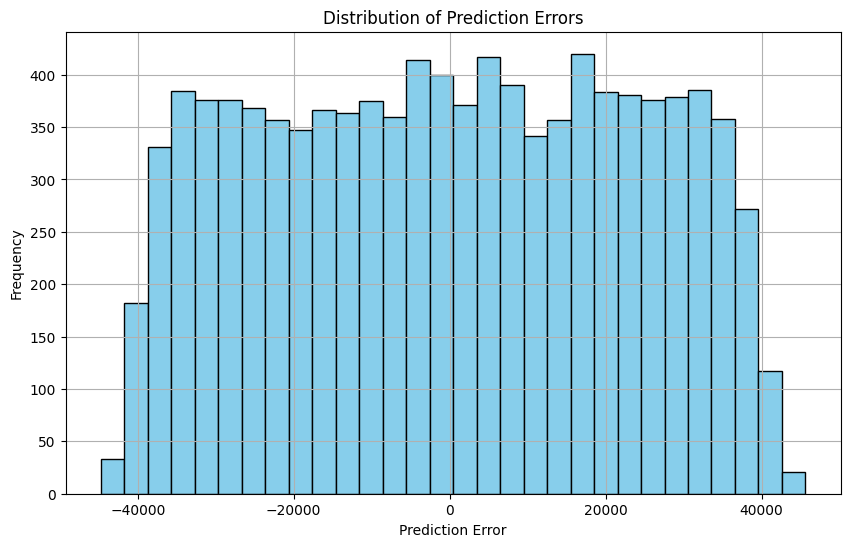

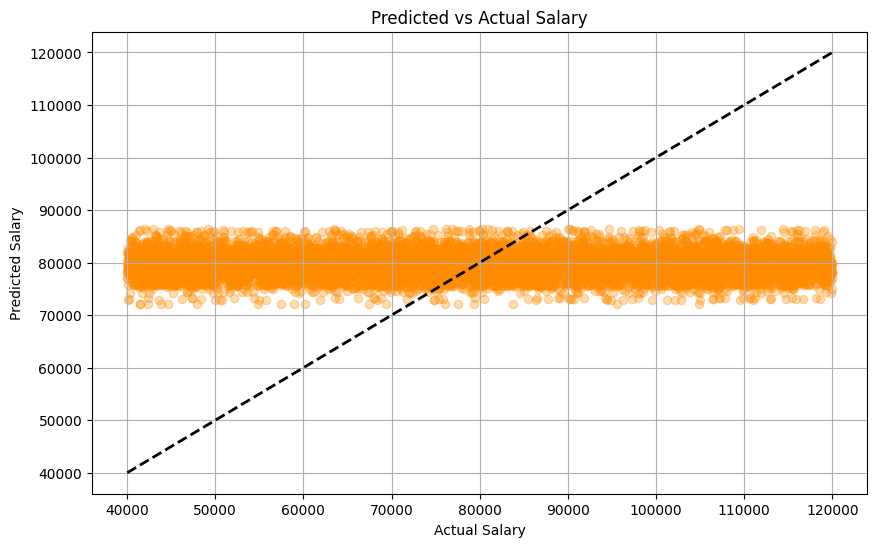

In [18]:
import matplotlib.pyplot as plt

# Plot 1: Distribution of prediction errors
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 2: Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs Actual Salary')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.grid(True)
plt.show()


In [19]:
import joblib
joblib.dump(model, 'model.pkl')

from azureml.core import Workspace, Model
ws = Workspace.from_config()
Model.register(workspace=ws, model_path="model.pkl", model_name="my_model_RegressionModel")

Registering model my_model_RegressionModel


Model(workspace=Workspace.create(name='wsbrownml', subscription_id='407f4106-0fd3-42e0-9348-3686dd1e7347', resource_group='rgbrownml'), name=my_model_RegressionModel, id=my_model_RegressionModel:1, version=1, tags={}, properties={})